In [1]:
import pandas as pd

# Install required libraries
!pip install cupy-cuda11x  # Replace '12x' with the appropriate version number
!pip install pandas mlxtend
%pip install pm4py
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from google.colab import drive
from pm4py.objects.log.importer.xes import importer as xes_importer

# Import necessary libraries
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=be125aacdb1fe7e9f361b76cfbbb789b3e23b9659a7116ffe5aa5a863ce0ef21
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/cupy/_environment.py:487: UserWarning: 
--------------------------------------------------------------------------------

  C

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="ipykernel.ipkernel")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Load Event Log (Read XES file and convert to DataFrame)
### pm4py uses dataframe as the standard format for event logs

drive.mount('/content/drive', force_remount=True)
log = pm4py.read_xes('/content/drive/MyDrive/BIS/Project/Files/Sepsis Cases - Event Log.xes/Sepsis Cases - Event Log.xes')
eventlog_df = pm4py.convert_to_dataframe(log)

# Preparing data // These steps are essential for ensuring that the DataFrame is in the correct format for further analysis or processing.
eventlog_df['time:timestamp']= pd.to_datetime(eventlog_df['time:timestamp'])  #converts the time:timestamp column to datetime format.
eventlog_df['Leucocytes'] = pd.to_numeric(eventlog_df['Leucocytes'], errors='coerce') #This line converts the Leucocytes column to numeric values, turning 'nan' strings to NaN values.
eventlog_df['LacticAcid'] = pd.to_numeric(eventlog_df['LacticAcid'], errors='coerce') #This line converts the LacticAcid column to numeric values, turning 'nan' strings to NaN values.
eventlog_df['CRP'] = pd.to_numeric(eventlog_df['CRP'], errors='coerce') #This line converts the CRP column to numeric values, turning 'nan' strings to NaN values.

# Sort by case ID and timestamp
eventlog_df = eventlog_df.sort_values(by=['case:concept:name', 'time:timestamp'])
eventlog_df

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,concept:name,...,DiagnosticLacticAcid,lifecycle:transition,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,case:concept:name,Leucocytes,CRP,LacticAcid
0,True,A,True,True,True,True,True,True,True,ER Registration,...,True,complete,A,False,True,True,A,NaN,NaN,NaN
1,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,complete,NaN,NaN,NaN,NaN,A,9.6,NaN,NaN
2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,21.0,NaN
3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LacticAcid,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,2.2
4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10228,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,ZZ,NaN,146.0,NaN
10229,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,complete,NaN,NaN,NaN,NaN,ZZ,8.3,NaN,NaN
10230,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,complete,NaN,NaN,NaN,NaN,ZZ,7.7,NaN,NaN
10231,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,ZZ,NaN,96.0,NaN


In [4]:
# Let's study the event log

#"IV" stands for intravenous. This term refers to the administration of substances directly into a vein.
#ER=Emergency Room

num_events = len(eventlog_df)
num_cases = len(eventlog_df['case:concept:name'].unique())
print("Nmber of events: {}\nNumber of cases: {}".format(num_events, num_cases))

start_activities = pm4py.get_start_activities(eventlog_df)
end_activities = pm4py.get_end_activities(eventlog_df)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Nmber of events: 15214
Number of cases: 1050
Start activities: {'ER Registration': 995, 'ER Sepsis Triage': 7, 'CRP': 10, 'Leucocytes': 18, 'IV Liquid': 14, 'ER Triage': 6}
End activities: {'Release A': 393, 'IV Antibiotics': 87, 'Return ER': 291, 'LacticAcid': 24, 'Admission NC': 14, 'CRP': 41, 'ER Sepsis Triage': 49, 'Leucocytes': 44, 'IV Liquid': 12, 'Release B': 55, 'Release E': 5, 'Release C': 19, 'Release D': 14, 'ER Triage': 2}


Average number of activities per case:
14.48952380952381


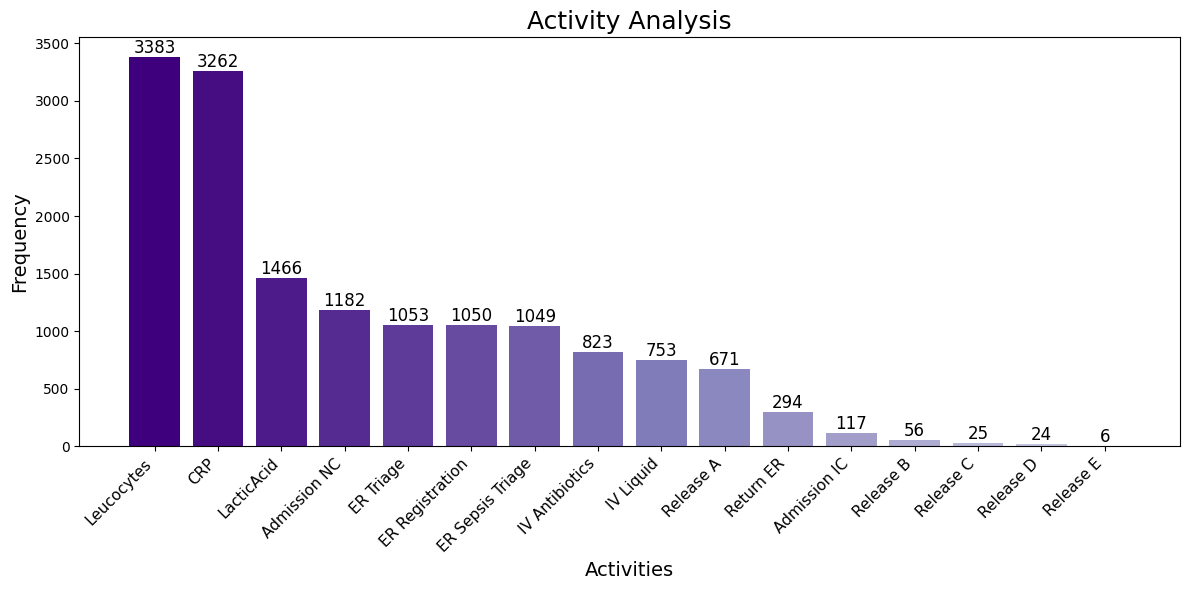

In [5]:
# Activity Analysis

# Get activity counts
activity_counts = pm4py.get_event_attribute_values(eventlog_df, 'concept:name')

# Extract the activity names and their counts
activities = list(activity_counts.keys())
counts = list(activity_counts.values())

# Calculate average number of activities per case
num_cases = len(eventlog_df['case:concept:name'].unique())
average_num_activities_per_case = sum(counts) / num_cases
print("Average number of activities per case:")
print(average_num_activities_per_case)

# Create a purple color palette
colors = plt.cm.Purples(np.linspace(1, 0.3, len(activities)))

plt.figure(figsize=(12, 6))
bars = plt.bar(activities, counts, color=colors)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Activities', fontsize=14)
plt.title('Activity Analysis', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=11)

# Add value labels to each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height()}',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

Mean Age: 70.08095238095238
Median Age: 75.0
Mode Age: 90.0
Standard Deviation of Age: 17.356743593960285


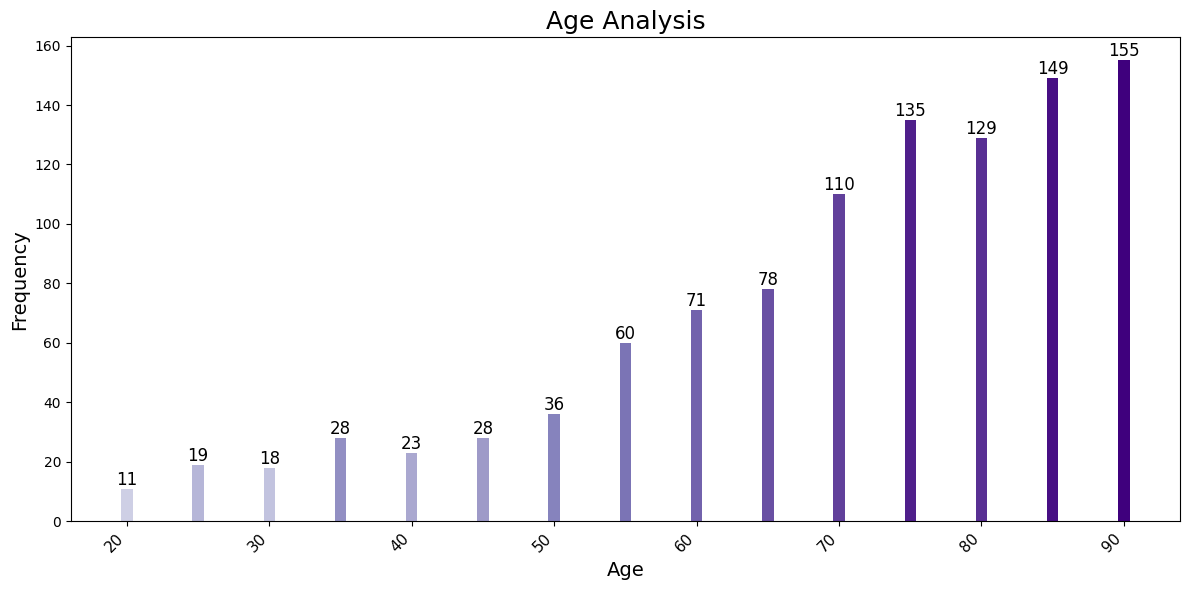

In [6]:
# Age Analysis
from statistics import mean, median, mode, stdev

# Get age counts
age_counts = pm4py.get_event_attribute_values(eventlog_df, 'Age')

# Extract the age categories and their counts
ages = list(age_counts.keys())
counts = list(age_counts.values())

# Calculate statistics
age_values = []
for age, count in zip(ages, counts):
    age_values.extend([age] * count)

age_mean = mean(age_values)
age_median = median(age_values)
age_mode = mode(age_values)
age_std = stdev(age_values)

print("Mean Age:", age_mean)
print("Median Age:", age_median)
print("Mode Age:", age_mode)
print("Standard Deviation of Age:", age_std)

# Create a purple color palette
colors = plt.cm.Purples(np.linspace(1, 0.3, len(ages)))

plt.figure(figsize=(12, 6))
bars = plt.bar(ages, counts, color=colors)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Age', fontsize=14)
plt.title('Age Analysis', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=11)

# Add value labels to each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height()}',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

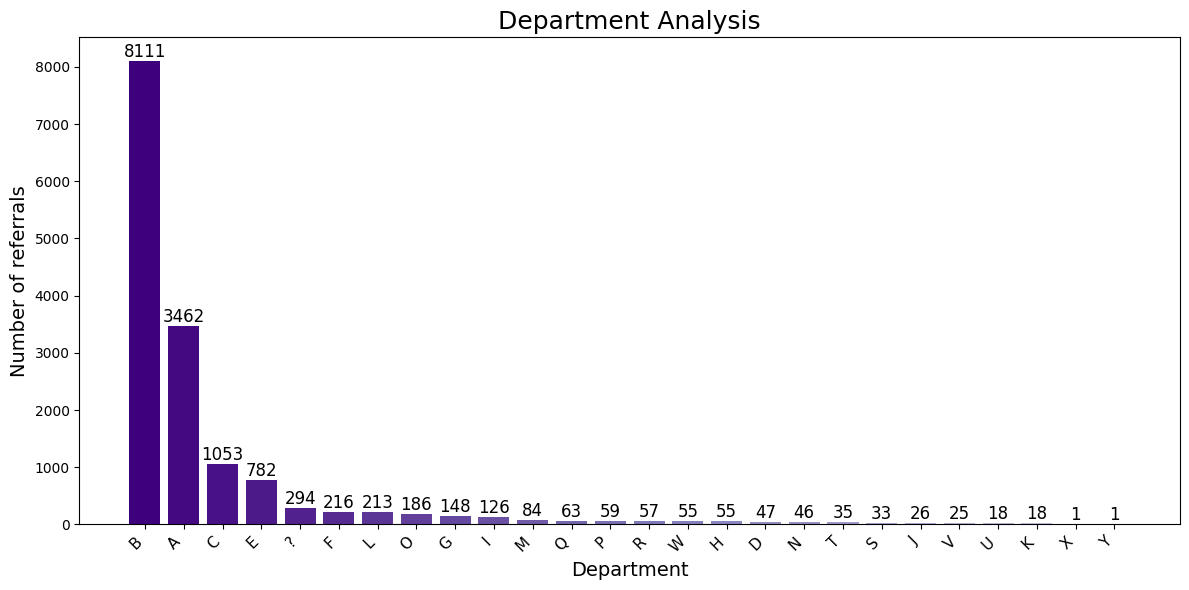

In [7]:
# Department Analysis

# Get activity counts
department_counts = pm4py.get_event_attribute_values(eventlog_df, 'org:group')

# Extract the activity names and their counts
activities = list(department_counts.keys())
counts = list(department_counts.values())

# Create a purple color palette
colors = plt.cm.Purples(np.linspace(1, 0.3, len(activities)))

plt.figure(figsize=(12, 6))
bars = plt.bar(activities, counts, color=colors)
plt.ylabel('Number of referrals', fontsize=14)
plt.xlabel('Department', fontsize=14)
plt.title('Department Analysis', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=11)

# Add value labels to each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height()}',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

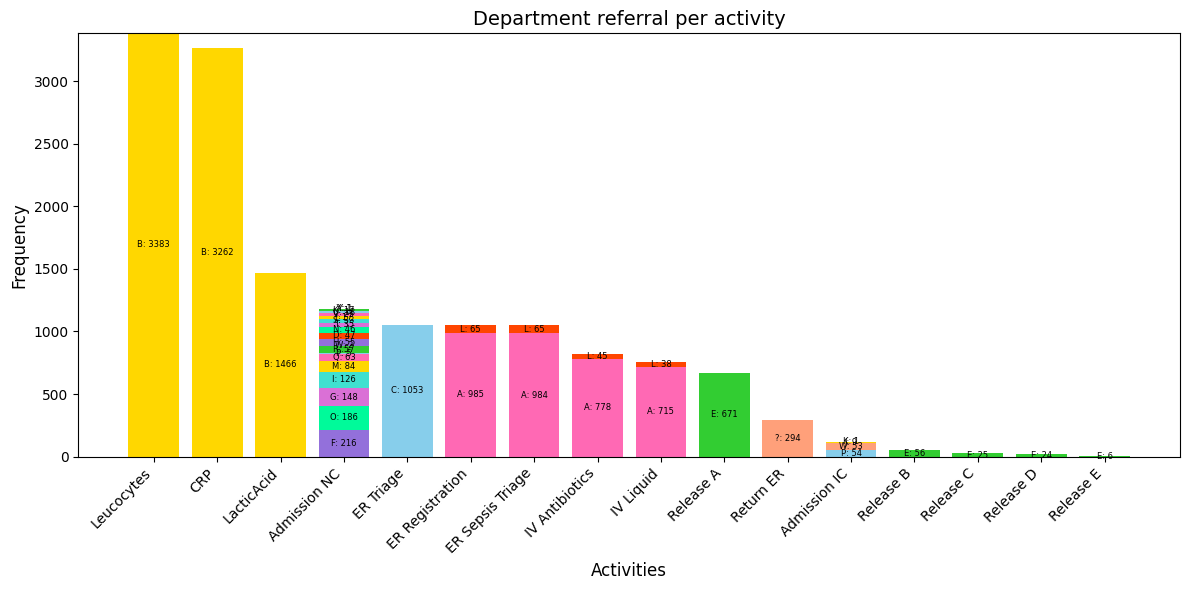

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pm4py

# Assuming you have a DataFrame named eventlog_df

# Extract the activity names and their counts
activity_counts = pm4py.get_event_attribute_values(eventlog_df, 'concept:name')
group_counts = pm4py.get_event_attribute_values(eventlog_df, 'org:group')

# Create a mapping of activities to their respective counts and organization groups
activity_group_counts = {}
for activity in activity_counts.keys():
    activity_group_counts[activity] = {}
    for group in group_counts.keys():
        activity_group_counts[activity][group] = len(eventlog_df[(eventlog_df['concept:name'] == activity) & (eventlog_df['org:group'] == group)])

# Extract unique organization groups
unique_groups = list(group_counts.keys())

# Sort activities by total counts for better visualization
sorted_activities = sorted(activity_group_counts.keys(), key=lambda x: sum(activity_group_counts[x].values()), reverse=True)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))

# Define a list of happy colors
happy_colors = [
    "#FFD700", # Gold
    "#FF69B4", # Hot Pink
    "#87CEEB", # Sky Blue
    "#32CD32", # Lime Green
    "#FFA07A", # Light Salmon
    "#9370DB", # Medium Purple
    "#FF4500", # Orange Red
    "#00FA9A", # Medium Spring Green
    "#DA70D6", # Orchid
    "#40E0D0"  # Turquoise
]

# Use the happy colors for plotting
bottom_counts = np.zeros(len(sorted_activities))
for i, group in enumerate(unique_groups):
    group_counts = [activity_group_counts[activity].get(group, 0) for activity in sorted_activities]
    color = happy_colors[i % len(happy_colors)]
    ax.bar(sorted_activities, group_counts, bottom=bottom_counts, color=color, label=group)
    bottom_counts += group_counts

# Set plot labels and title with adjusted fontsize
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Activities', fontsize=12)
ax.set_title('Department referral per activity', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Add value labels to each bar segment with adjusted fontsize
for i, activity in enumerate(sorted_activities):
    bottom = 0
    for j, group in enumerate(unique_groups):
        count = activity_group_counts[activity].get(group, 0)
        if count > 0:
            ax.text(i, bottom + count / 2, f'{group}: {count}', ha='center', va='center', fontsize=6, color='black')
        bottom += count

plt.show()


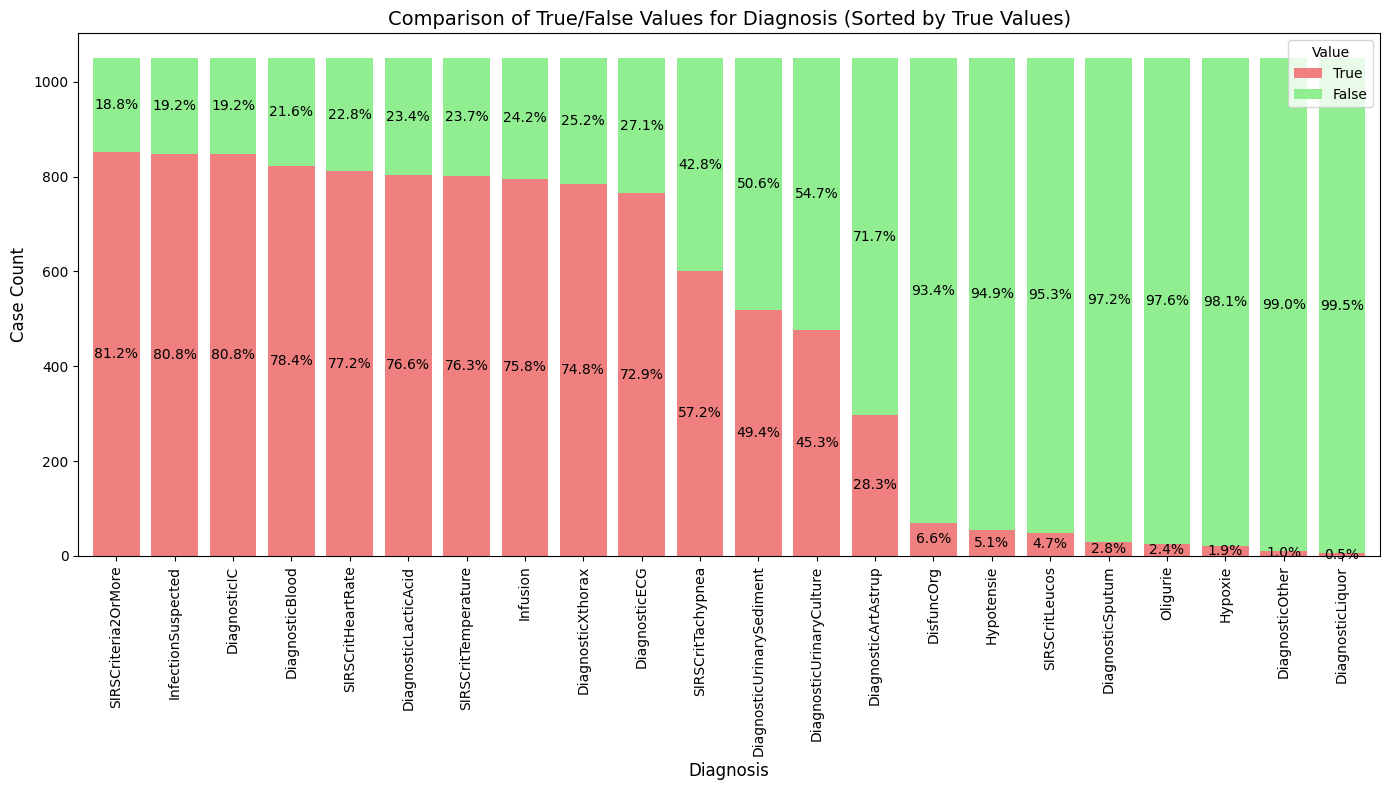

In [9]:
# Analysis of the rest of the attributes

# Sort by case ID and timestamp
eventlog_df = eventlog_df.sort_values(by=['case:concept:name', 'time:timestamp'])

# Select columns with boolean values
boolean_columns = [
    'InfectionSuspected', 'DiagnosticBlood', 'DisfuncOrg', 'SIRSCritTachypnea',
    'Hypotensie', 'SIRSCritHeartRate', 'Infusion', 'DiagnosticArtAstrup', 'DiagnosticIC',
    'DiagnosticSputum', 'DiagnosticLiquor', 'DiagnosticOther', 'SIRSCriteria2OrMore',
    'DiagnosticXthorax', 'SIRSCritTemperature', 'DiagnosticUrinaryCulture', 'SIRSCritLeucos',
    'Oligurie', 'DiagnosticLacticAcid', 'Hypoxie', 'DiagnosticUrinarySediment',
    'DiagnosticECG'
]

# Count true/false values for each column
true_counts = eventlog_df[boolean_columns].sum()
false_counts = eventlog_df[boolean_columns].count() - true_counts

# Create a DataFrame for plotting
comparison_df = pd.DataFrame({'True': true_counts, 'False': false_counts})

# Sort comparison_df based on True values in descending order
comparison_df = comparison_df.sort_values(by='True', ascending=False)

# Plotting with adjusted color and bar width
ax = comparison_df.plot(kind='bar', stacked=True, figsize=(14, 8), color=['lightcoral', 'lightgreen'], width=0.8)

# Annotate bars with percentage values
total_counts = true_counts + false_counts
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width / 2, y + height / 2, f'{height/total_counts[int(x)]:.1%}', ha='center', va='center')

plt.title('Comparison of True/False Values for Diagnosis (Sorted by True Values)', fontsize=14)
plt.xlabel('Diagnosis', fontsize=12)
plt.ylabel('Case Count', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.legend(title='Value', labels=['True', 'False'])
plt.tight_layout()
plt.show()


In [10]:
# Number of cases with missing or zero values in 'Leucocytes', 'CRP' and 'LacticAcid' columns

# Function to count non-null occurrences in a column for each case
def count_non_null(group, column):
    return group[column].notna().sum()

# Group by case and calculate the counts for each specified column
count_aggregations = eventlog_df.groupby('case:concept:name').apply(lambda x: pd.Series({
    'Leucocytes_events_count': count_non_null(x, 'Leucocytes'),
    'CRP_events_count': count_non_null(x, 'CRP'),
    'LacticAcid_events_count': count_non_null(x, 'LacticAcid')
})).reset_index()

problematic_cases_any = count_aggregations[
    (count_aggregations['Leucocytes_events_count'] == 0) |
    (count_aggregations['Leucocytes_events_count'].isna()) |
    (count_aggregations['CRP_events_count'] == 0) |
    (count_aggregations['CRP_events_count'].isna()) |
    (count_aggregations['LacticAcid_events_count'] == 0) |
    (count_aggregations['LacticAcid_events_count'].isna())
]['case:concept:name'].nunique()

# Number of cases with missing or zero values in Leucocytes_events_count
problematic_cases_leucocytes = count_aggregations[
    (count_aggregations['Leucocytes_events_count'] == 0) |
    (count_aggregations['Leucocytes_events_count'].isna())
]['case:concept:name'].nunique()

# Number of cases with missing or zero values in CRP_events_count
problematic_cases_crp = count_aggregations[
    (count_aggregations['CRP_events_count'] == 0) |
    (count_aggregations['CRP_events_count'].isna())
]['case:concept:name'].nunique()

# Number of cases with missing or zero values in LacticAcid_events_count
problematic_cases_lactic_acid = count_aggregations[
    (count_aggregations['LacticAcid_events_count'] == 0) |
    (count_aggregations['LacticAcid_events_count'].isna())
]['case:concept:name'].nunique()

# Print the results
#print(f"Total number of cases: {total_cases}")
print(f"Number of cases with missing or zero value in Leucocytes_events_count: {problematic_cases_leucocytes}")
print(f"Number of cases with missing or zero value in CRP_events_count: {problematic_cases_crp}")
print(f"Number of cases with missing or zero value in LacticAcid_events_count: {problematic_cases_lactic_acid}")
print(f"Total number of cases with missing or zero value in any of the count columns: {problematic_cases_any}")

Number of cases with missing or zero value in Leucocytes_events_count: 39
Number of cases with missing or zero value in CRP_events_count: 103
Number of cases with missing or zero value in LacticAcid_events_count: 193
Total number of cases with missing or zero value in any of the count columns: 214


In [11]:
# Dropping cases with missing or zero values in 'Leucocytes', 'CRP' and 'LacticAcid' columns

# Function to count non-null occurrences in a column for each case
def count_non_null(group, column):
    return group[column].notna().sum()

# Group by case and calculate the counts for each specified column
count_aggregations = eventlog_df.groupby('case:concept:name').apply(lambda x: pd.Series({
    'Leucocytes_events_count': count_non_null(x, 'Leucocytes'),
    'CRP_events_count': count_non_null(x, 'CRP'),
    'LacticAcid_events_count': count_non_null(x, 'LacticAcid')
})).reset_index()

# Number of cases with missing or zero values in any count column
problematic_cases_any = count_aggregations[
    (count_aggregations['Leucocytes_events_count'] == 0) |
    (count_aggregations['Leucocytes_events_count'].isna()) |
    (count_aggregations['CRP_events_count'] == 0) |
    (count_aggregations['CRP_events_count'].isna()) |
    (count_aggregations['LacticAcid_events_count'] == 0) |
    (count_aggregations['LacticAcid_events_count'].isna())
]['case:concept:name']

# Drop cases with missing or zero values in any count column from log_df
eventlog_df = eventlog_df[~eventlog_df['case:concept:name'].isin(problematic_cases_any)]

# Total number of cases after dropping problematic cases
total_cases = eventlog_df['case:concept:name'].nunique()

print(f"Total number of cases after dropping problematic cases: {total_cases}")

Total number of cases after dropping problematic cases: 836


In [12]:
# Let's study the event log after dropping Null values

#"IV" stands for intravenous. This term refers to the administration of substances directly into a vein.
#ER=Emergency Room

num_events = len(eventlog_df)
num_cases = len(eventlog_df['case:concept:name'].unique())
print("Nmber of events: {}\nNumber of cases: {}".format(num_events, num_cases))

start_activities = pm4py.get_start_activities(eventlog_df)
end_activities = pm4py.get_end_activities(eventlog_df)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Nmber of events: 13522
Number of cases: 836
Start activities: {'ER Registration': 791, 'CRP': 6, 'Leucocytes': 13, 'IV Liquid': 14, 'ER Sepsis Triage': 6, 'ER Triage': 6}
End activities: {'Release A': 340, 'IV Antibiotics': 76, 'Return ER': 266, 'LacticAcid': 22, 'Admission NC': 12, 'Leucocytes': 16, 'IV Liquid': 9, 'Release B': 49, 'Release E': 3, 'CRP': 13, 'Release C': 16, 'Release D': 11, 'ER Triage': 1, 'ER Sepsis Triage': 2}


In [13]:
#Filter the eventlog_df DataFrame to retain only the cases that start and end with one of the specified activities. This ensures that only cases with these specific start and end activities are included in filtered_log.
filtered_log = pm4py.filter_end_activities(eventlog_df, ['Release A', 'Release B', 'Release C', 'Release D', 'Release E', 'Return ER'])

#Filter above filtered_log to retain only the cases that start with one of the specified activities. This ensures that only cases with these specific start activities are included in the final filtered_log.
filtered_log = pm4py.filter_start_activities(filtered_log, ['ER Registration', 'ER Sepsis Triage', 'ER Triage'])

print("Given {} total cases in the log we have {} cases that comply with constraints for complete cases".format(num_cases,len(filtered_log['case:concept:name'].unique())))
filtered_log

Given 836 total cases in the log we have 655 cases that comply with constraints for complete cases


,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,concept:name,...,DiagnosticLacticAcid,lifecycle:transition,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,case:concept:name,Leucocytes,CRP,LacticAcid
0,True,A,True,True,True,True,True,True,True,ER Registration,...,True,complete,A,False,True,True,A,NaN,NaN,NaN
1,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,complete,NaN,NaN,NaN,NaN,A,9.6,NaN,NaN
2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,21.0,NaN
3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LacticAcid,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,2.2
4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10228,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,ZZ,NaN,146.0,NaN
10229,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,complete,NaN,NaN,NaN,NaN,ZZ,8.3,NaN,NaN
10230,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,complete,NaN,NaN,NaN,NaN,ZZ,7.7,NaN,NaN
10231,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,ZZ,NaN,96.0,NaN


In [14]:
# Let's study the filtered log
num_events = len(filtered_log)
num_cases = len(filtered_log['case:concept:name'].unique())
print("Number of events after filtering: {}\nNumber of cases after filtering: {}".format(num_events, num_cases))

start_activities = pm4py.get_start_activities(filtered_log)
end_activities = pm4py.get_end_activities(filtered_log)
print("Start activities after filtering: {}\nEnd activities after filtering: {}".format(start_activities, end_activities))

Number of events after filtering: 11566
Number of cases after filtering: 655
Start activities after filtering: {'ER Registration': 646, 'ER Sepsis Triage': 5, 'ER Triage': 4}
End activities after filtering: {'Release A': 327, 'Return ER': 257, 'Release B': 44, 'Release E': 3, 'Release C': 14, 'Release D': 10}


In [15]:
# Calculate the duration of each case  => and sort them
case_durations = filtered_log.groupby('case:concept:name').agg(\
Events=('case:concept:name', 'count'),\
# Multiple aggregations of the same column using pandas ... => Python LAmbda is a variable which can be updated during the calculation
CaseStart=('time:timestamp', lambda x: x.min()),
CaseEnd=('time:timestamp', lambda x: x.max()),
CaseDuration=('time:timestamp', lambda x: x.max() - x.min()),
#Case_name=('case:concept:name', 'first'),
)

# Calculate Duration_day separately
case_durations['Total_Duration(Day)'] = case_durations['CaseDuration'].dt.days

# Merge the calculated durations back into the filtered_log
#filtered_log = filtered_log.merge(case_durations[['case:concept:name', 'Duration']], on='case:concept:name', how='left')

sorted_cases = case_durations.sort_values(by='CaseDuration', ascending=True)
sorted_cases

,Events,CaseStart,CaseEnd,CaseDuration,Total_Duration(Day)
case:concept:name,,,,,
FQ,8,2014-03-08 08:40:34,2014-03-08 11:55:00,0 days 03:14:26,0
PBA,11,2014-04-27 15:01:49,2014-04-27 22:55:00,0 days 07:53:11,0
TR,8,2014-04-02 08:03:30,2014-04-02 16:15:00,0 days 08:11:30,0
QFA,8,2014-01-16 16:31:27,2014-01-17 05:50:00,0 days 13:18:33,0
CN,11,2014-01-01 17:06:57,2014-01-02 09:00:00,0 days 15:53:03,0
...,...,...,...,...,...
UBA,15,2014-05-08 11:58:15,2015-05-30 11:14:55,386 days 23:16:40,386
LS,15,2013-11-18 17:24:56,2014-12-20 16:39:26,396 days 23:14:30,396
ZS,14,2013-11-14 11:58:51,2014-12-18 10:08:54,398 days 22:10:03,398


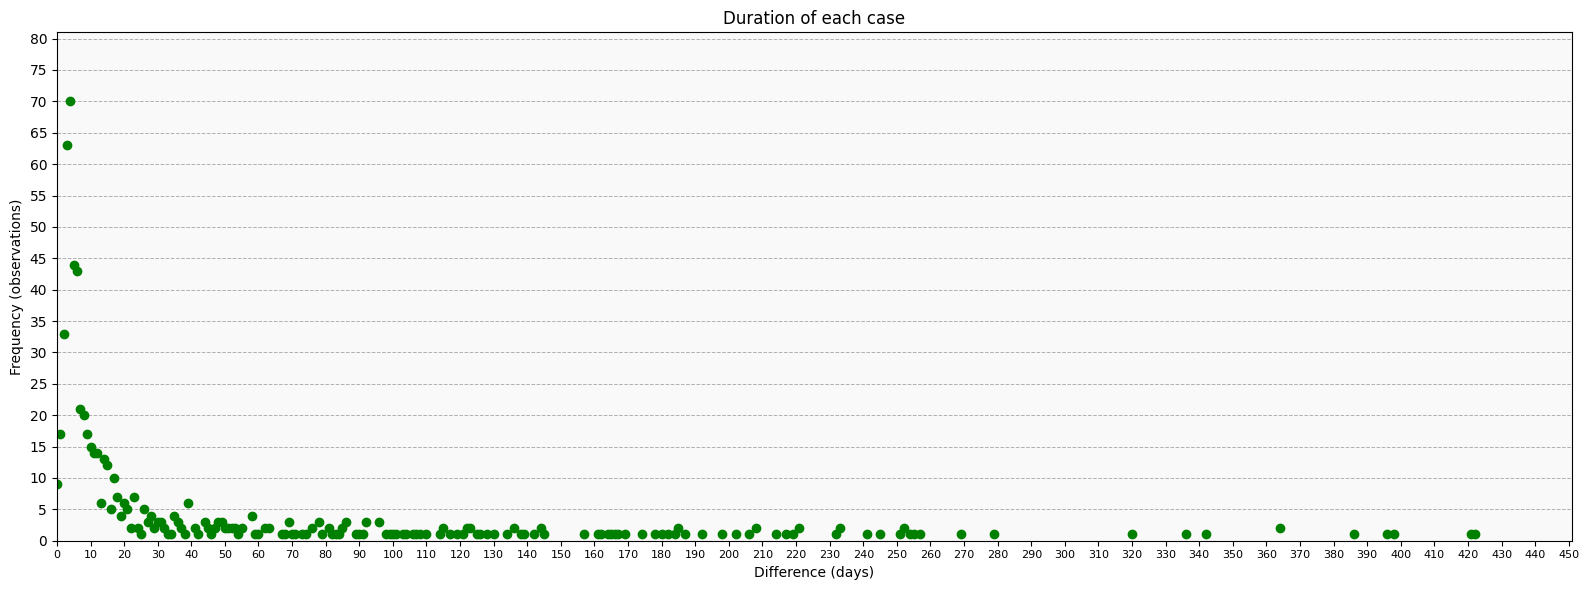

Mean of the differences: 39 days 08:37:54.983206107
Median of the differences: 9 days 17:44:14
Mode Duration: 11666000000000 nanoseconds
Standard Deviation: 68 days 22:38:32.899655564


In [16]:
# Calculate frequency of durations
frequency = case_durations.groupby('Total_Duration(Day)').size().reset_index(name='Count')

# Define graph
plt.figure(figsize=(16, 6))
plt.plot(frequency['Total_Duration(Day)'], frequency['Count'],'o', color='green')

# Set labels and title
plt.xlabel('Difference (days)')
plt.ylabel('Frequency (observations)')
plt.title('Duration of each case')

# Set axis limits
plt.xlim(0, 451)
plt.ylim(0, 81)

# Add more labels on the axis
plt.xticks(np.arange(0, 451, 10), fontsize=8)
plt.yticks(np.arange(0, 81, 5), fontsize=6)
plt.yticks(fontsize=10)

# More style
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.gca().set_facecolor('#f9f9f9')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

mean_difference = case_durations['CaseDuration'].mean()
print(f"Mean of the differences: {mean_difference}")

median_difference = case_durations['CaseDuration'].median()
print(f"Median of the differences: {median_difference}")

modee=case_durations['CaseDuration'].mode().values[0]
print('Mode Duration:',modee)

# Calculate standard deviation
std_deviation = np.std(case_durations['CaseDuration'], ddof=1)
print("Standard Deviation:", std_deviation)


In [17]:
# Calculate the cumulativetime time per case for each event also the Total Duration

# Create a pivot table of the start (minimum) and end (maximum) timestamps associated with each case
#case_starts_ends = filtered_log.pivot_table(index='case:concept:name', aggfunc={'time:timestamp': ['min', 'max']})
#case_starts_ends = case_starts_ends.reset_index()
#case_starts_ends.columns = ['case:concept:name', 'casestart', 'caseend']

# Merge with the main event log data so that for each row we have the start and end times.
filtered_log = filtered_log.merge(case_durations, on='case:concept:name', suffixes=('', '_y'))

# Filter out the cases where Total_Duration(Day) is greater than 280
filtered_log = filtered_log[filtered_log['Total_Duration(Day)'] <= 280]

# Calculate tnecessary relative times
#filtered_log['Total_Duration'] = filtered_log['CaseEnd'] - filtered_log['CaseStart']
filtered_log['cumulativetime'] = filtered_log['time:timestamp'] - filtered_log['CaseStart']
## days
filtered_log['cumulativedays'] = filtered_log['cumulativetime'].dt.days
## hours
filtered_log['cumulativetime_h'] = filtered_log['cumulativetime'].dt.seconds/3600 + 86400*filtered_log['cumulativetime'].dt.days
## seconds
filtered_log['cumulativetime_s'] = filtered_log['cumulativetime'].dt.seconds + 86400*filtered_log['cumulativetime'].dt.days

filtered_log

,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,concept:name,...,LacticAcid,Events,CaseStart,CaseEnd,CaseDuration,Total_Duration(Day),cumulativetime,cumulativedays,cumulativetime_h,cumulativetime_s
0,True,A,True,True,True,True,True,True,True,ER Registration,...,NaN,22,2014-10-22 11:15:41,2014-11-02 15:15:00,11 days 03:59:19,11,0 days 00:00:00,0,0.000000,0
1,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,22,2014-10-22 11:15:41,2014-11-02 15:15:00,11 days 03:59:19,11,0 days 00:11:19,0,0.188611,679
2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,22,2014-10-22 11:15:41,2014-11-02 15:15:00,11 days 03:59:19,11,0 days 00:11:19,0,0.188611,679
3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LacticAcid,...,2.2,22,2014-10-22 11:15:41,2014-11-02 15:15:00,11 days 03:59:19,11,0 days 00:11:19,0,0.188611,679
4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,22,2014-10-22 11:15:41,2014-11-02 15:15:00,11 days 03:59:19,11,0 days 00:17:56,0,0.298889,1076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11561,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,14,2014-11-12 16:34:30,2014-11-17 18:00:00,5 days 01:25:30,5,1 days 14:25:30,1,86414.425000,138330
11562,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,14,2014-11-12 16:34:30,2014-11-17 18:00:00,5 days 01:25:30,5,1 days 14:25:30,1,86414.425000,138330
11563,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,14,2014-11-12 16:34:30,2014-11-17 18:00:00,5 days 01:25:30,5,3 days 14:25:30,3,259214.425000,311130
11564,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,14,2014-11-12 16:34:30,2014-11-17 18:00:00,5 days 01:25:30,5,3 days 14:25:30,3,259214.425000,311130


In [18]:
# Retrieve the variants of the conformant event logs, creates a DataFrame from the variants dictionary
variants = pm4py.get_variants(filtered_log)
variants_df = pd.DataFrame.from_dict(variants, orient='index', columns=['Count'])
variants_df = variants_df.reset_index()
variants_df = variants_df.rename(columns={'index': 'Variant'})
variants_df = variants_df.sort_values(by=['Count'], ascending=False)
variants_df = variants_df.reset_index(drop=True)
variants_df

,Variant,Count
0,"(ER Registration, ER Triage, ER Sepsis Triage,...",4
1,"(ER Registration, ER Triage, ER Sepsis Triage,...",4
2,"(ER Registration, ER Triage, ER Sepsis Triage,...",4
3,"(ER Registration, ER Triage, ER Sepsis Triage,...",3
4,"(ER Registration, ER Triage, ER Sepsis Triage,...",3
...,...,...
605,"(ER Registration, ER Triage, ER Sepsis Triage,...",1
606,"(ER Registration, ER Triage, ER Sepsis Triage,...",1
607,"(ER Registration, ER Sepsis Triage, ER Triage,...",1
608,"(ER Registration, ER Triage, ER Sepsis Triage,...",1


In [19]:
from pm4py.algo.filtering.log.variants import variants_filter

# Get the variants and their counts
variants_count = variants_filter.get_variants(filtered_log)

# Create a dictionary to store the counts of each trace
trace_counts = {}

for variant, cases in variants_count.items():
    trace = tuple(variant)  # Ensure the variant is in tuple format
    count = len(cases)
    if trace in trace_counts:
        trace_counts[trace] += count
    else:
        trace_counts[trace] = count

# Sort the trace_counts dictionary by count in descending order
sorted_trace_counts = sorted(trace_counts.items(), key=lambda item: item[1], reverse=True)

# Print the number of cases for each unique trace with more than 1 occurrence
for trace, count in sorted_trace_counts:
    if count > 1:  # Only print traces with more than 1 occurrence
        print(f"Number of cases of trace {trace}: {count}")

Number of cases of trace ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'LacticAcid', 'Leucocytes', 'CRP', 'IV Liquid', 'IV Antibiotics', 'Admission NC', 'Release A'): 4
Number of cases of trace ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'LacticAcid', 'CRP', 'IV Liquid', 'IV Antibiotics', 'Admission NC', 'CRP', 'Leucocytes', 'Release A'): 4
Number of cases of trace ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP', 'LacticAcid', 'IV Liquid', 'IV Antibiotics', 'Admission NC', 'Leucocytes', 'CRP', 'Release A'): 4
Number of cases of trace ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'IV Liquid', 'Leucocytes', 'CRP', 'LacticAcid', 'IV Antibiotics', 'Admission NC', 'Leucocytes', 'CRP', 'Release A', 'Return ER'): 3
Number of cases of trace ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP', 'LacticAcid', 'IV Liquid', 'IV Antibiotics', 'Admission NC', 'CRP', 'Release A', 'Return ER'): 3
Number of cases of trace

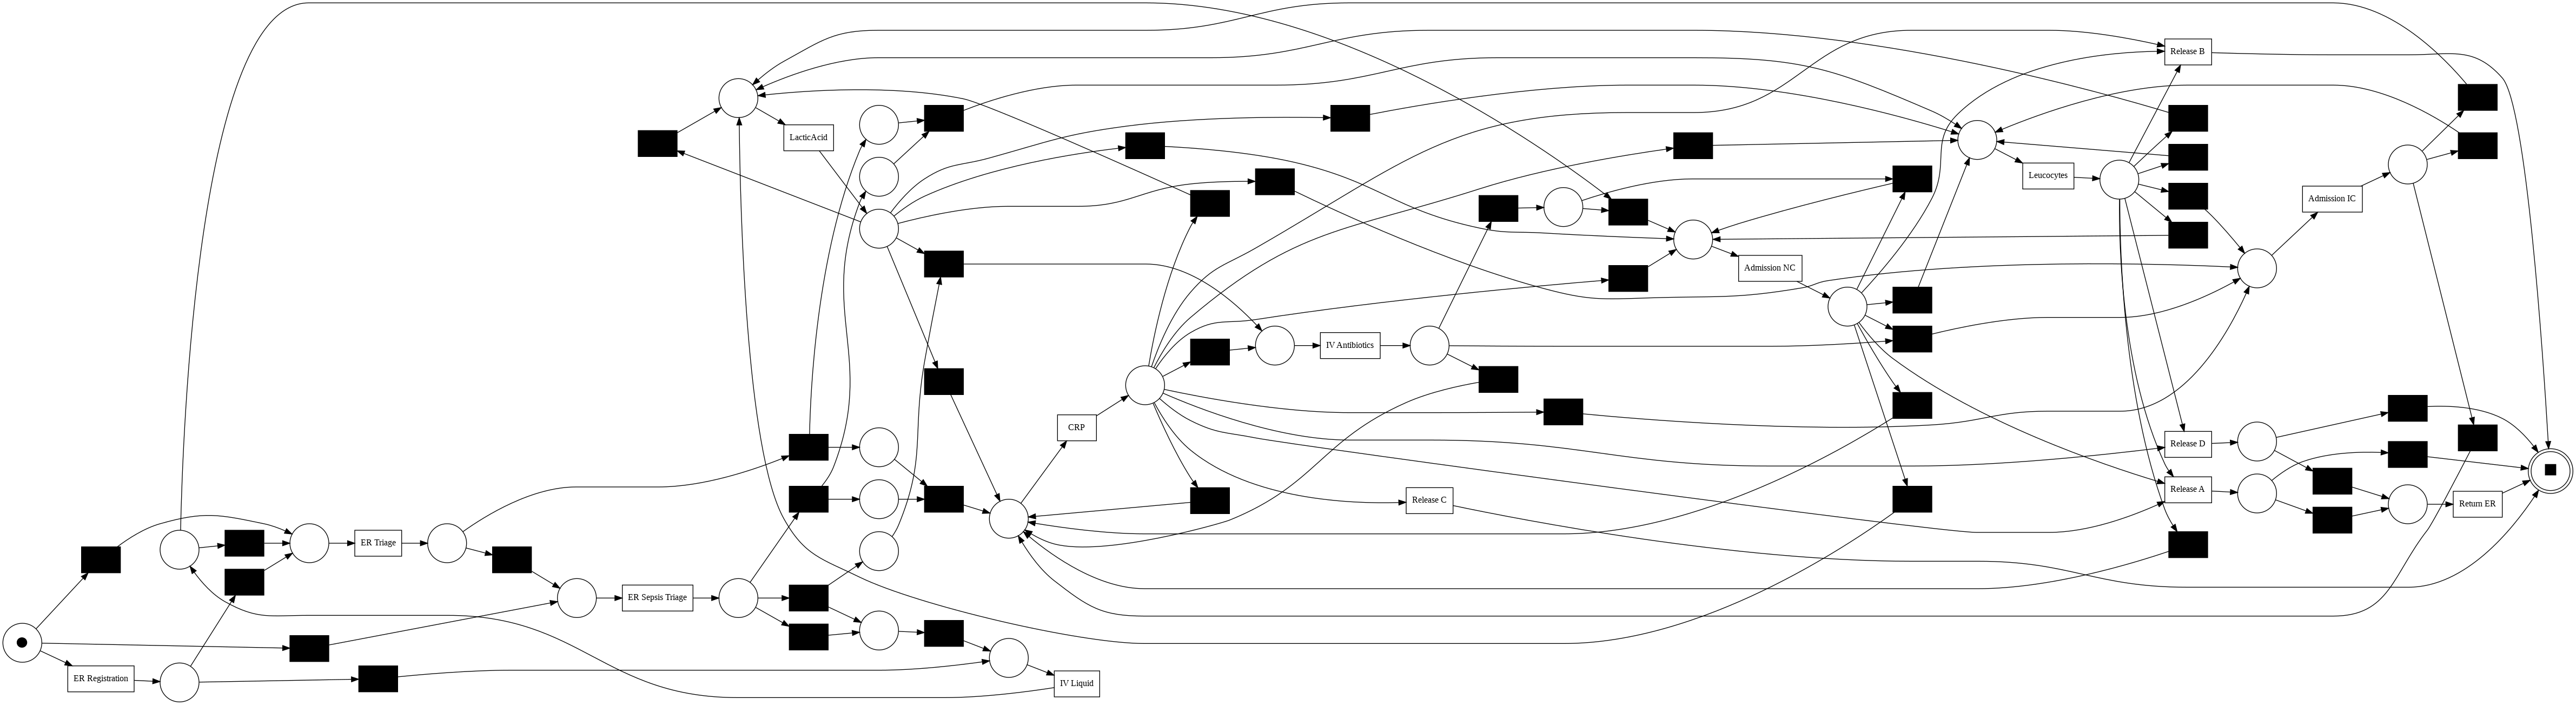

In [20]:
# Discover the model with Heuristic Miner

net, im, fm = pm4py.discover_petri_net_heuristics(filtered_log, dependency_threshold=0.9)
pm4py.view_petri_net(net, im, fm, format='png')

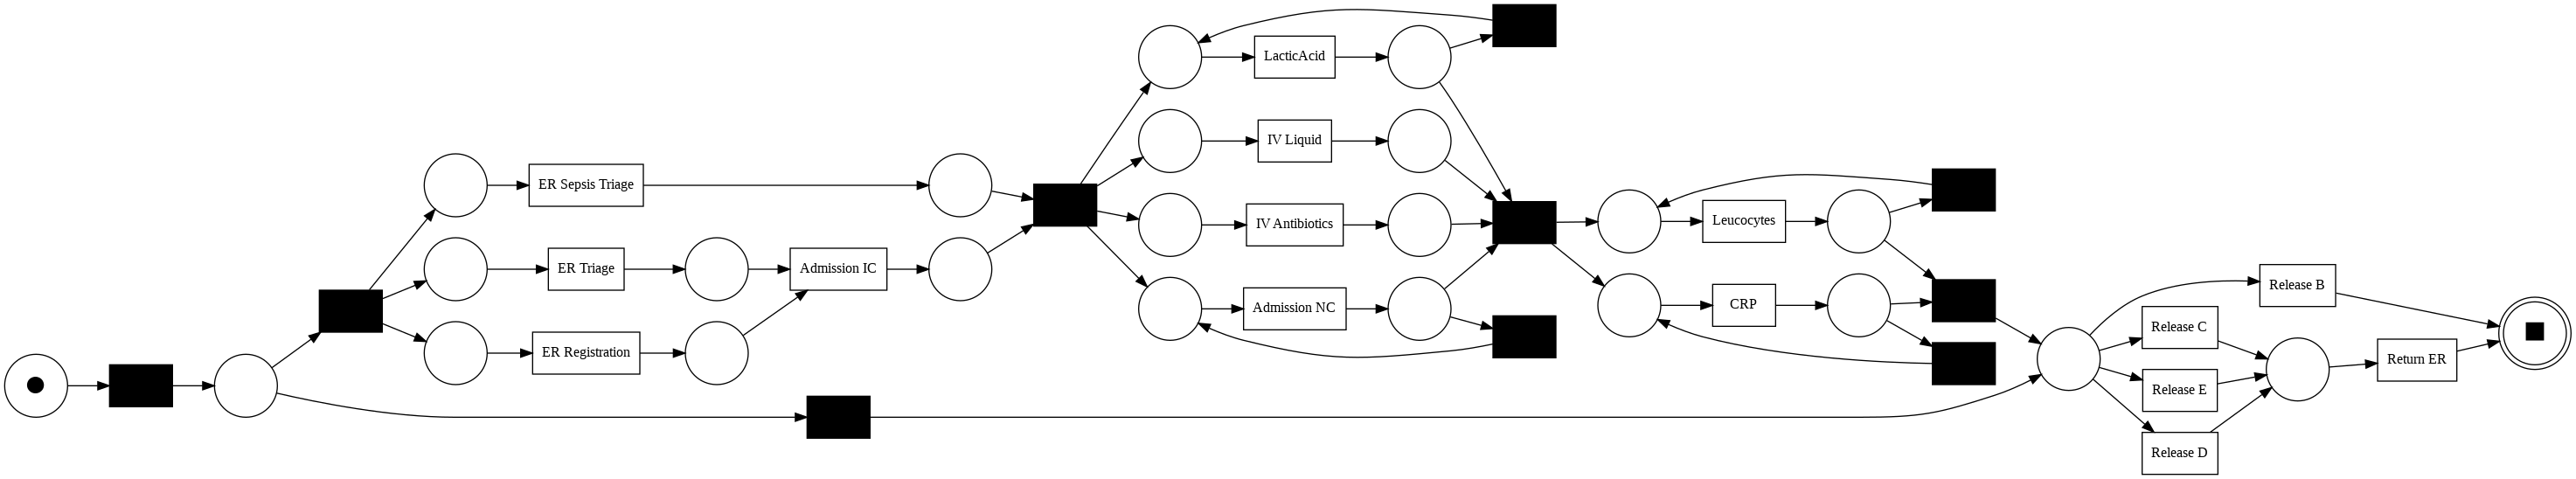

In [21]:
# Discover the process model with Inductive Miner

net, im, fm = pm4py.discover_petri_net_inductive(filtered_log, noise_threshold= 0.9)
pm4py.view_petri_net(net, im, fm, format='png')

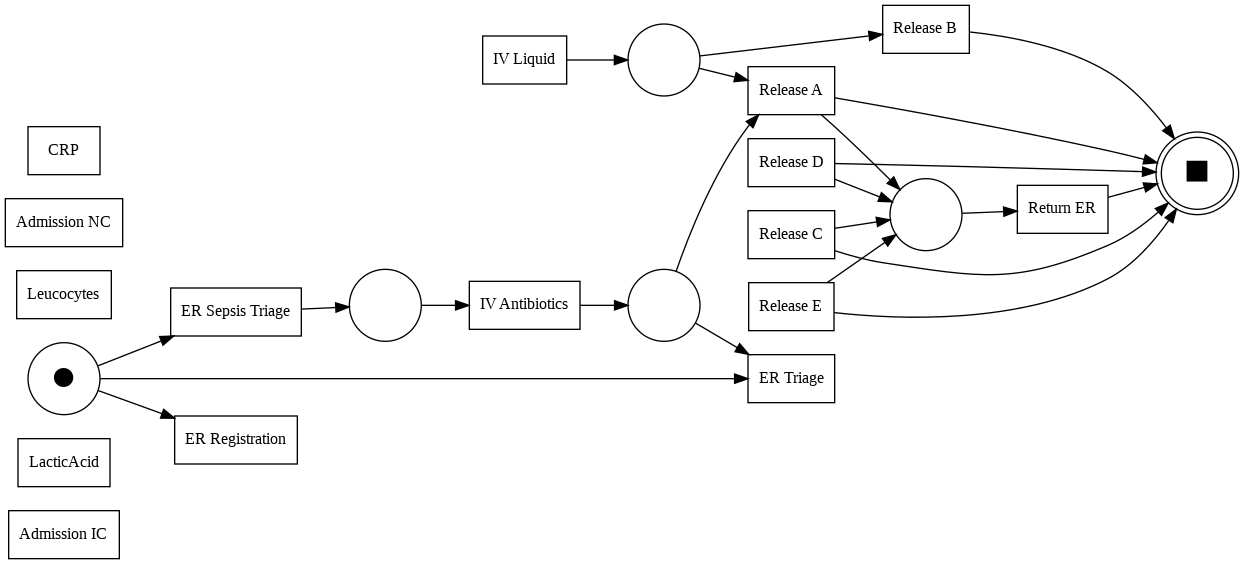

In [22]:
## Alpha_miner algorithm
net, im, fm = pm4py.discover_petri_net_alpha(filtered_log)

# Visualise
pm4py.view_petri_net(net, im, fm, format='png')

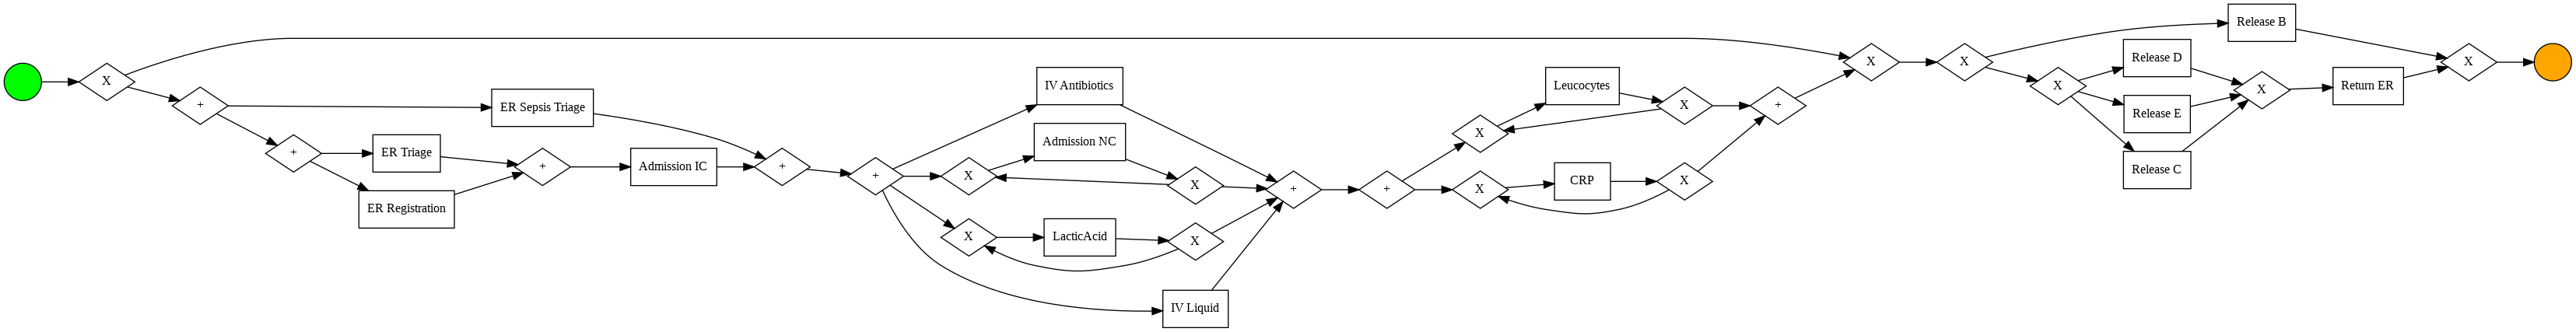

In [23]:
# Discover the process model with BPMN Miner

bpmn_model = pm4py.discover_bpmn_inductive(filtered_log, noise_threshold=0.9)
pm4py.view_bpmn(bpmn_model, format='png')

In [24]:
#Fitness, Precision, Generalization and Simplicity

# Step 1: Evaluate Fitness
fitness_eval = pm4py.algo.evaluation.replay_fitness.algorithm.apply(
     log=filtered_log,
     petri_net=net,
     initial_marking=im,
     final_marking=fm
)

# Print Fitness evaluation
print(f"Fitness: {fitness_eval['log_fitness']}")

# Step 2: Evaluate Precision
precision_eval = pm4py.algo.evaluation.precision.algorithm.apply(
     log=filtered_log,
     net=net,
     marking=im,  # Initial marking
     final_marking=fm  # Final marking
)

# Print Precision evaluation
print(f"Precision: {precision_eval}")

# Step 3: Evaluate Generalization
generalization_eval = pm4py.algo.evaluation.generalization.algorithm.apply(
     log=filtered_log,
     petri_net=net,
     initial_marking=im,  # Initial marking

     final_marking=fm  # Final marking
)

# Print Generalization evaluation
print(f"Generalization: {generalization_eval}")

# Step 4: Evaluate Simplicity
simplicity_eval = pm4py.algo.evaluation.simplicity.algorithm.apply(
     petri_net=net,
     parameters={"variant": pm4py.algo.evaluation.simplicity.algorithm.Variants.SIMPLICITY_ARC_DEGREE}
 )

# Print simplicity evaluation
print(f"Simplicity: {simplicity_eval}")

aligning log, completed variants ::   0%|          | 0/610 [00:00<?, ?it/s]

Fitness: 0.7428250281004121


computing precision with alignments, completed variants ::   0%|          | 0/4878 [00:00<?, ?it/s]

Precision: 0.19249965969417848


replaying log with TBR, completed traces ::   0%|          | 0/610 [00:00<?, ?it/s]

Generalization: 0.8996666814581679
Simplicity: 1.0


In [25]:
# Conformance checking diagnostic CONFORMANCE CHECKING
## Define optional parameters
opt_parameters = {'return_object_names': True}

tbr_diagnostics = pm4py.conformance_diagnostics_token_based_replay(filtered_log, net, im, fm, return_diagnostics_dataframe = True)
# Using the parameter return_diagnostics_dataframe we can obtain diagnostics in DF format and this provide us with case_id
tbr_diagnostics

replaying log with TBR, completed traces ::   0%|          | 0/610 [00:00<?, ?it/s]

,case_id,is_fit,trace_fitness,missing,remaining,produced,consumed
0,A,False,0.729167,3,1,6,8
1,AAA,False,0.761905,3,1,7,9
2,ABA,False,0.729167,3,1,6,8
3,AC,False,0.761905,3,1,7,9
4,AD,False,0.761905,3,1,7,9
...,...,...,...,...,...,...,...
640,ZU,False,0.729167,3,1,6,8
641,ZV,False,0.729167,3,1,6,8
642,ZW,False,0.729167,3,1,6,8
643,ZX,False,0.729167,3,1,6,8


replaying log with TBR, completed traces ::   0%|          | 0/610 [00:00<?, ?it/s]

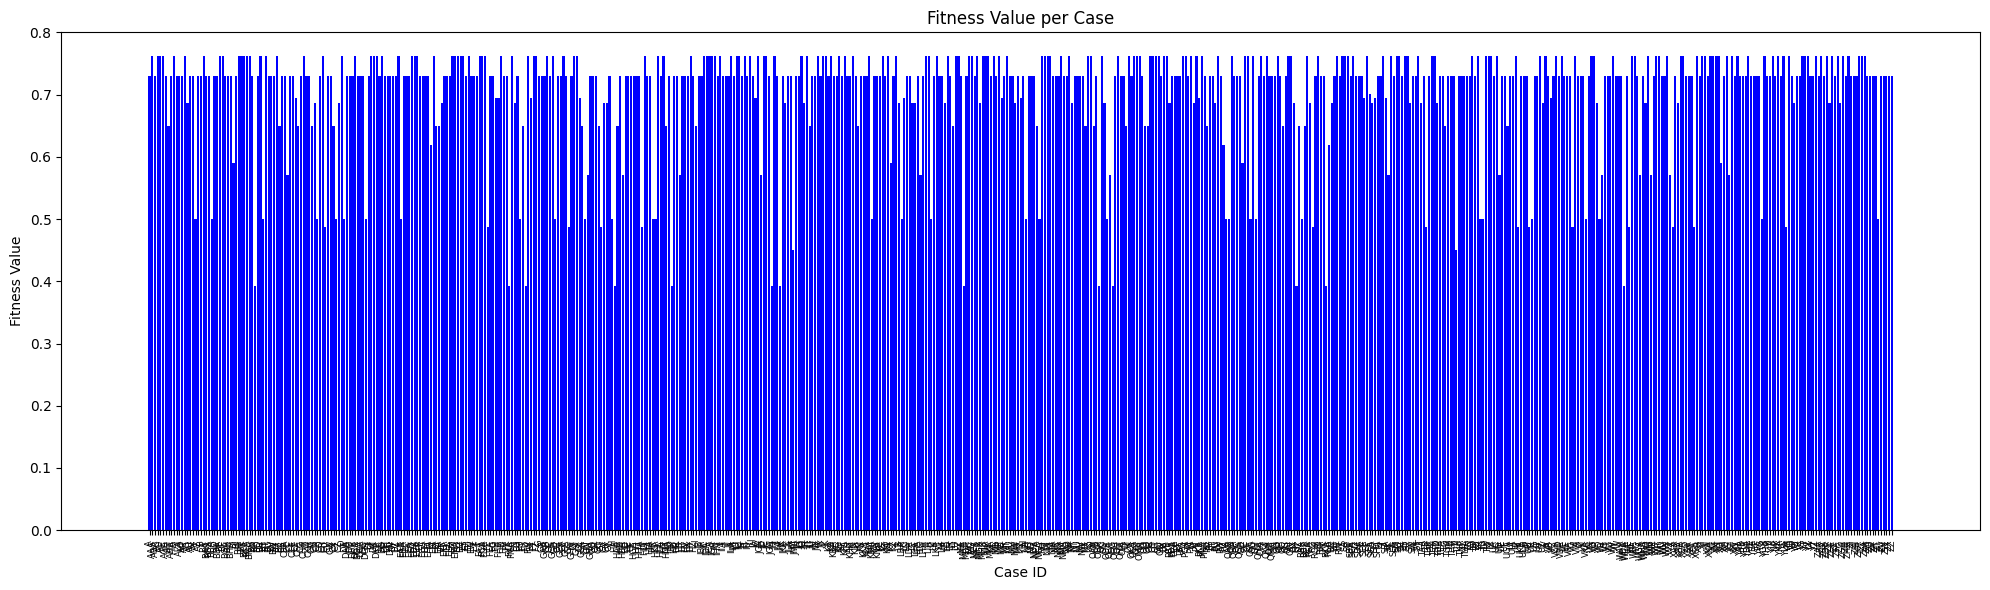

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import pm4py

# Assuming filtered_log, net, im, and fm are already defined
# Define optional parameters
opt_parameters = {'return_object_names': True}

# Run the token-based replay diagnostic
tbr_diagnostics = pm4py.conformance_diagnostics_token_based_replay(filtered_log, net, im, fm, return_diagnostics_dataframe=True)

# Extract fitness values and case_ids
fitness_df = tbr_diagnostics[['case_id', 'is_fit', 'trace_fitness']]

# Aggregate fitness values (mean fitness value per case)
fitness_summary = fitness_df.groupby('case_id')['trace_fitness'].mean().reset_index()

# Create a bar chart for fitness values
plt.figure(figsize=(20, 6))
plt.bar(fitness_summary['case_id'], fitness_summary['trace_fitness'], color='blue')
plt.xlabel('Case ID')
plt.ylabel('Fitness Value')
plt.title('Fitness Value per Case')
plt.xticks(rotation=90, fontsize=6)  # Rotate x-axis labels for better readability and reduce font size
plt.tight_layout()

# Display the chart
plt.show()


In [27]:
#Filter disfunctional cases

## Get the Case_ID of the cases with low fitness values(Disfunctional traces) => Filter based on CaseID
disfuntional_traces = tbr_diagnostics['case_id'][tbr_diagnostics['trace_fitness'] <= 0.5].tolist()
print(len(disfuntional_traces))
print(disfuntional_traces)

61
['AY', 'BCA', 'BP', 'BS', 'CP', 'CU', 'CY', 'DA', 'DGA', 'EAA', 'FE', 'FKA', 'FQ', 'FU', 'GD', 'GG', 'GM', 'GT', 'H', 'HA', 'HI', 'HK', 'HKA', 'HP', 'JGA', 'JJA', 'JM', 'KMA', 'LBA', 'LJ', 'MAA', 'NA', 'NGA', 'OBA', 'ODA', 'OG', 'QA', 'QAA', 'QFA', 'QH', 'QY', 'RAA', 'RG', 'RKA', 'TB', 'TI', 'TR', 'TS', 'UK', 'UQ', 'UR', 'VG', 'VKA', 'VQ', 'WBA', 'WE', 'X', 'XFA', 'YG', 'YLA', 'ZT']


In [28]:
## Apply a filter to remove the list of disfunctional cases based on CaseID ('case:concept:name')
filtered_dataframe = pm4py.filter_event_attribute_values(filtered_log, 'case:concept:name', disfuntional_traces, retain=False)

In [29]:
num_events = len(filtered_dataframe)
num_cases = len(filtered_dataframe['case:concept:name'].unique())
print("Nmber of events: {}\nNumber of cases: {}".format(num_events, num_cases))

start_activities = pm4py.get_start_activities(filtered_dataframe)
end_activities = pm4py.get_end_activities(filtered_dataframe)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Nmber of events: 10234
Number of cases: 584
Start activities: {'ER Registration': 575, 'ER Sepsis Triage': 5, 'ER Triage': 4}
End activities: {'Release A': 314, 'Return ER': 233, 'Release B': 37}


In [30]:
# Create High_Probability_Sepsis_cases segment

# CRP more than 50 MG/L:
# Leucocytes (WBC) less than 4000/μl or more than 12000/μl:
# LacticAcid more than 2.0 MG/L:

print('Filtred log: ',len(filtered_dataframe['case:concept:name'].unique()))

# segmentCRP50: CRP more than 50 MG/L
CasesCRPRisk = filtered_dataframe[filtered_dataframe['CRP'] >= 50]['case:concept:name'].unique()
segmentCRP50 = filtered_dataframe[filtered_dataframe['case:concept:name'].isin(CasesCRPRisk)]
print('\nCRP more than 50 MG/L: ',len(segmentCRP50['case:concept:name'].unique()))

# segmentLeucocyteRisk: Leucocytes less than 4000/μl or more than 12000/μl.
condition = (filtered_dataframe['Leucocytes'] < 4) | (filtered_dataframe['Leucocytes'] >= 12)
CasesLeucocyteRisk = filtered_dataframe[condition]['case:concept:name'].unique()
segmentLeucocyteRisk = filtered_dataframe[filtered_dataframe['case:concept:name'].isin(CasesLeucocyteRisk)]
print('Leucocytes less than 4,000/μl or more than 12,000/μl: ',len(segmentLeucocyteRisk['case:concept:name'].unique()))

#	segmentLacticRisk: LacticAcid levels > 2.0 MGL
CasesLacticRisk = filtered_dataframe[filtered_dataframe['LacticAcid'] >= 2]['case:concept:name'].unique()
segmentLacticRisk = filtered_dataframe[filtered_dataframe['case:concept:name'].isin(CasesLacticRisk)]
print('LacticAcid more than 2.0 MG/L: ',len(segmentLacticRisk['case:concept:name'].unique()))

#	segmentTwoOrMore_SIRS_criteria: SIRSCriteria2OrMore
#CasesTwoOrMore_SIRS_criteria = filtered_log[filtered_log['SIRSCriteria2OrMore'] == True]['case:concept:name'].unique()
#segmentTwoOrMore_SIRS_criteria = filtered_log[filtered_log['case:concept:name'].isin(CasesTwoOrMore_SIRS_criteria)]
#print('segmentTwoOrMore_SIRS_criteria: ', len(segmentTwoOrMore_SIRS_criteria['case:concept:name'].unique()))


# Create a union of all cases
#high_probability_sepsis_cases = set(segmentTwoOrMore_SIRS_criteria).union(set(CasesLeucocyteRisk), set(CasesLacticRisk), set(segmentCRP50))
high_probability_sepsis_cases = set(CasesCRPRisk).union(set(CasesLeucocyteRisk), set(CasesLacticRisk))

# Filter the original log to include only the cases in the combined segment
high_probability_sepsis_segment = filtered_dataframe[filtered_dataframe['case:concept:name'].isin(high_probability_sepsis_cases)]

print('Total umber of cases which have at least one symptom: ', len(high_probability_sepsis_segment['case:concept:name'].unique()))

Filtred log:  584

CRP more than 50 MG/L:  520
Leucocytes less than 4,000/μl or more than 12,000/μl:  423
LacticAcid more than 2.0 MG/L:  239
Total umber of cases which have at least one symptom:  571


In [31]:
# Start/End activities in Suspicious Cases
start_activities_suspicious_cases = pm4py.get_start_activities(high_probability_sepsis_segment)
end_activities_suspicious_cases = pm4py.get_end_activities(high_probability_sepsis_segment)
print("Start activities_suspicious_cases: {}\nEnd activities_suspicious_cases: {}".format(start_activities, end_activities))

# Start/End activities in segmentCRP50
start_activities_CRP = pm4py.get_start_activities(segmentCRP50)
end_activities_CRP = pm4py.get_end_activities(segmentCRP50)
print("\nStart activities_CRP: {}\nEnd activities_CRP: {}".format(start_activities_CRP, end_activities_CRP))

# Start/End activities in segmentLeucocyteRisk
start_activities_Leucocyte = pm4py.get_start_activities(segmentLeucocyteRisk)
end_activities_Leucocyte = pm4py.get_end_activities(segmentLeucocyteRisk)
print("\nStart activities_Leucocyte: {}\nEnd activities_Leucocyte: {}".format(start_activities_Leucocyte, end_activities_Leucocyte))

# Start/End activities in segmentLacticRisk
start_activities_Lactic = pm4py.get_start_activities(segmentLacticRisk)
end_activities_Lactic = pm4py.get_end_activities(segmentLacticRisk)
print("\nStart activities_Lactic: {}\nEnd activities_Lactic: {}".format(start_activities_Lactic, end_activities_Lactic))

Start activities_suspicious_cases: {'ER Registration': 575, 'ER Sepsis Triage': 5, 'ER Triage': 4}
End activities_suspicious_cases: {'Release A': 314, 'Return ER': 233, 'Release B': 37}

Start activities_CRP: {'ER Registration': 512, 'ER Sepsis Triage': 5, 'ER Triage': 3}
End activities_CRP: {'Release A': 275, 'Return ER': 209, 'Release B': 36}

Start activities_Leucocyte: {'ER Registration': 417, 'ER Triage': 3, 'ER Sepsis Triage': 3}
End activities_Leucocyte: {'Release A': 219, 'Return ER': 176, 'Release B': 28}

Start activities_Lactic: {'ER Registration': 234, 'ER Sepsis Triage': 3, 'ER Triage': 2}
End activities_Lactic: {'Release A': 119, 'Return ER': 100, 'Release B': 20}


In [32]:
# Lift Value: Evaluting the significance of the correlation of two variables in a segment

# segmentCRP50
var1_CRP = len(segmentCRP50['case:concept:name'].unique()) / len(high_probability_sepsis_segment['case:concept:name'].unique())
var2_CRP = 232/len(high_probability_sepsis_segment['case:concept:name'].unique())

liftvalue_CRP = (214/len(segmentCRP50['case:concept:name'].unique()))/(var1_CRP * var2_CRP)
print('CRP Segment Lift Value: ',liftvalue_CRP)

# segmentLeucocyteRisk
var1_Leucocyte = len(segmentLeucocyteRisk['case:concept:name'].unique()) / len(high_probability_sepsis_segment['case:concept:name'].unique())
var2_Leucocyte = 232/len(high_probability_sepsis_segment['case:concept:name'].unique())

liftvalue_Leucocyte = (179/len(segmentLeucocyteRisk['case:concept:name'].unique()))/(var1_Leucocyte * var2_Leucocyte)
print('Leucocyte Segment Lift Value: ',liftvalue_Leucocyte)

# segmentLacticRisk
var1_Lactic = len(segmentLacticRisk['case:concept:name'].unique()) / len(high_probability_sepsis_segment['case:concept:name'].unique())
var2_Lactic = 232/len(high_probability_sepsis_segment['case:concept:name'].unique())

liftvalue_Lactic = (102/len(segmentLacticRisk['case:concept:name'].unique()))/(var1_Lactic * var2_Lactic)
print('LacticAcid Segment Lift Value: ',liftvalue_Lactic)

CRP Segment Lift Value:  1.1122215810548868
Leucocyte Segment Lift Value:  1.4059067881095584
LacticAcid Segment Lift Value:  2.5095080980544022


In [33]:
# Analyse the performance of the hospital

# Identify the first occurrence of 'IV Antibiotics' for each case
first_iv_antibiotics = filtered_dataframe[filtered_dataframe['concept:name'] == 'IV Antibiotics'].groupby('case:concept:name').first().reset_index()

# Filter the cases where the cumulative hours are less than one hour
filtered_log_antibiotics = first_iv_antibiotics[first_iv_antibiotics['cumulativetime_h'] < 1]

# Get unique case names for IV Antibiotics
filtered_log_antibiotics_unique = filtered_log_antibiotics['case:concept:name'].unique()

##################################################

# Identify the first occurrence of 'IV Liquid' for each case
first_iv_Liquid = filtered_dataframe[filtered_dataframe['concept:name'] == 'IV Liquid'].groupby('case:concept:name').first().reset_index()

# Filter the cases where the cumulative hours are less than one hour
filtered_log_Liquid = first_iv_Liquid[first_iv_Liquid['cumulativetime_h'] < 1]

# Get unique case names for IV Liquid
filtered_log_Liquid_unique = filtered_log_Liquid['case:concept:name'].unique()

##################################################

# Find cases that meet all three conditions
Cases_short_admissions = set(filtered_log_antibiotics_unique).intersection(filtered_log_Liquid_unique)

# Find cases that do not meet all three conditions
Filtered_log_cases = filtered_dataframe['case:concept:name'].unique()
Filtered_log_cases = set(Filtered_log_cases)  # Convert to set if not already a set

# Now perform the set subtraction
Cases_not_short_admissions = Filtered_log_cases - Cases_short_admissions

# Add short_admission column based on Cases_short_admissions
filtered_dataframe.loc[filtered_dataframe['case:concept:name'].isin(Cases_short_admissions), 'short_admission'] = True

# Add short_admission column based on Cases_not_short_admissions
filtered_dataframe.loc[filtered_dataframe['case:concept:name'].isin(Cases_not_short_admissions), 'short_admission'] = False

print("\nGiven {} number of cases with high risk of Sepsis, there are {} cases where their first administration of 'IV Antibiotics' is less than 1 hour.".format(len(filtered_dataframe['case:concept:name'].unique()), len(filtered_log_antibiotics_unique)))
print("Given {} number of cases with high risk of Sepsis, there are {} cases where their first administration of 'IV Liquid' is less than 1 hour.".format(len(filtered_dataframe['case:concept:name'].unique()), len(filtered_log_Liquid_unique)))
print("There are {} cases that meet all 2 medical guidelines for sepsis treatment.".format(len(Cases_short_admissions)))
print("The cases that meet both medical guidelines for sepsis treatment: {}".format(list(Cases_short_admissions)))
print("There are {} cases that dont meet 2 medical guidelines for sepsis treatment.".format(len(Cases_not_short_admissions)))
print("The cases that meet both medical guidelines for sepsis treatment: {}".format(list(Cases_not_short_admissions)))



Given 584 number of cases with high risk of Sepsis, there are 205 cases where their first administration of 'IV Antibiotics' is less than 1 hour.
Given 584 number of cases with high risk of Sepsis, there are 278 cases where their first administration of 'IV Liquid' is less than 1 hour.
There are 190 cases that meet all 2 medical guidelines for sepsis treatment.
The cases that meet both medical guidelines for sepsis treatment: ['FG', 'KH', 'EU', 'BR', 'ZLA', 'ON', 'HV', 'ZI', 'JMA', 'RT', 'SE', 'FW', 'MR', 'RFA', 'SM', 'VS', 'YFA', 'XAA', 'PGA', 'KIA', 'BJ', 'RK', 'XKA', 'TBA', 'JC', 'MU', 'PBA', 'QIA', 'WCA', 'VDA', 'QHA', 'BHA', 'SA', 'ALA', 'CW', 'THA', 'KK', 'JE', 'ML', 'IBA', 'DK', 'DDA', 'IEA', 'NR', 'ZKA', 'SCA', 'TQ', 'FK', 'BA', 'ZM', 'VCA', 'GC', 'NDA', 'AU', 'MW', 'OHA', 'HR', 'UE', 'VR', 'DAA', 'JV', 'EF', 'OU', 'VO', 'IU', 'AHA', 'QN', 'KHA', 'XT', 'ZO', 'YDA', 'IB', 'DJ', 'BF', 'KA', 'PU', 'VE', 'OX', 'WFA', 'GV', 'GJA', 'BW', 'CV', 'EX', 'KB', 'RW', 'O', 'LL', 'JN', 'ZL'

/usr/local/lib/python3.10/dist-packages/cudf/pandas/fast_slow_proxy.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return fn(*args, **kwargs)


In [34]:
# Segment of filtered_dataframe where admmision of both Antibiotic and Liquid is done in less than 1 hour
log_short_admissions = filtered_dataframe[filtered_dataframe['case:concept:name'].isin(Cases_short_admissions)]

# Segment of filtered_dataframe where admmision of both Antibiotic and Liquid is done in less than 1 hour
log_long_admissions = filtered_dataframe[filtered_dataframe['case:concept:name'].isin(Cases_not_short_admissions)]


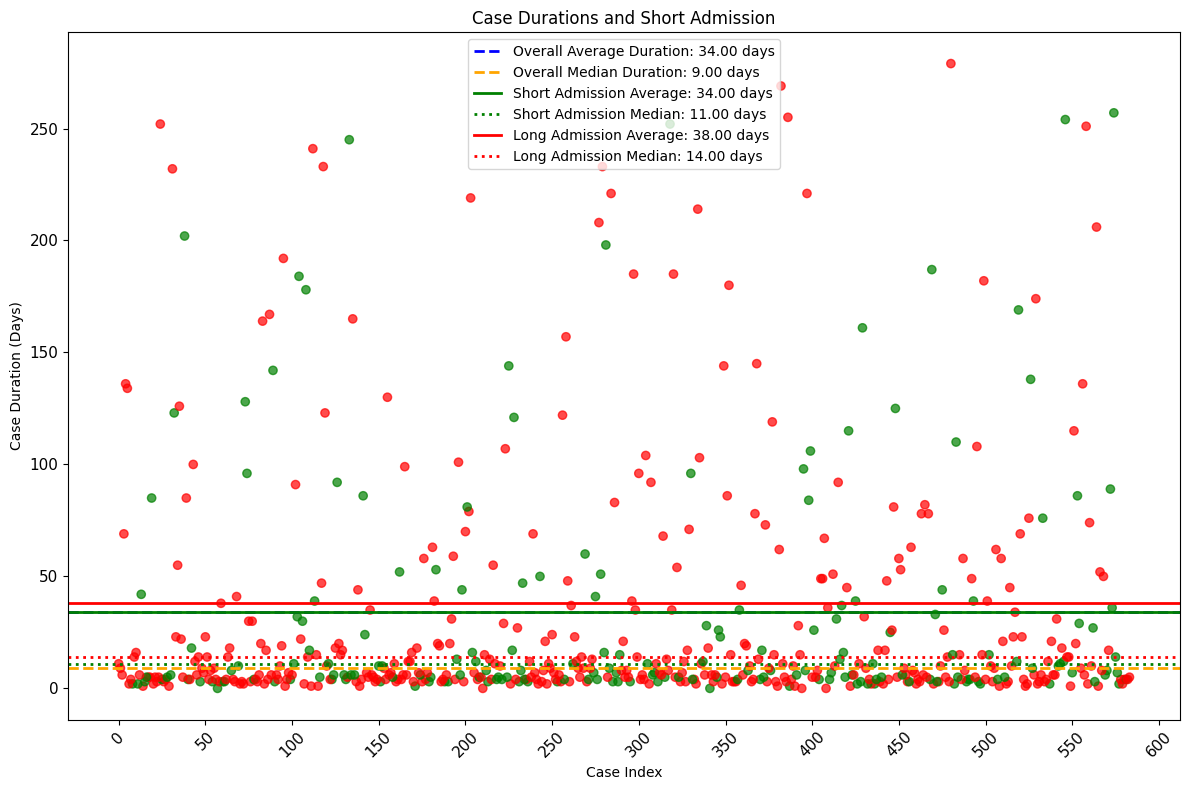

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate duration per case
case_duration_list = filtered_dataframe.groupby('case:concept:name')['CaseDuration'].first().dropna().reset_index()

# Sort case durations by duration
case_duration_list.sort_values(by='CaseDuration', inplace=True)

# Calculate statistics for short admissions
mean_short = log_short_admissions['CaseDuration'].mean()
median_short = log_short_admissions['CaseDuration'].median()
mode_short = log_short_admissions['CaseDuration'].mode()[0]
std_short = log_short_admissions['CaseDuration'].std()

# Calculate statistics for long admissions
mean_long = log_long_admissions['CaseDuration'].mean()
median_long = log_long_admissions['CaseDuration'].median()
mode_long = log_long_admissions['CaseDuration'].mode()[0]
std_long = log_long_admissions['CaseDuration'].std()

# Plotting the case durations
plt.figure(figsize=(12, 8))

# Define colors based on short_admission
short_admissions = case_duration_list['case:concept:name'].isin(Cases_short_admissions)
colors = np.where(short_admissions, 'green', 'red')

# Create scatter plot
plt.scatter(case_duration_list.index, case_duration_list['CaseDuration'].dt.days, c=colors, alpha=0.7)  # Use .dt.days if CaseDuration is in timedelta

plt.xlabel('Case Index', fontsize=10)
plt.ylabel('Case Duration (Days)', fontsize=10)
plt.title('Case Durations and Short Admission', fontsize=12)

# Add average and median lines for overall data
mean_duration = case_duration_list['CaseDuration'].mean().days
median_duration = case_duration_list['CaseDuration'].median().days

plt.axhline(y=mean_duration, color='blue', linestyle='--', linewidth=2, label=f'Overall Average Duration: {mean_duration:.2f} days')
plt.axhline(y=median_duration, color='orange', linestyle='--', linewidth=2, label=f'Overall Median Duration: {median_duration:.2f} days')

# Plot statistics for short admissions
plt.axhline(y=mean_short.days, color='green', linestyle='-', linewidth=2, label=f'Short Admission Average: {mean_short.days:.2f} days')
plt.axhline(y=median_short.days, color='green', linestyle=':', linewidth=2, label=f'Short Admission Median: {median_short.days:.2f} days')

# Plot statistics for long admissions
plt.axhline(y=mean_long.days, color='red', linestyle='-', linewidth=2, label=f'Long Admission Average: {mean_long.days:.2f} days')
plt.axhline(y=median_long.days, color='red', linestyle=':', linewidth=2, label=f'Long Admission Median: {median_long.days:.2f} days')

# Adjusting tick positions and labels
tick_positions_cases = np.arange(0, len(case_duration_list) + 50, 50)
plt.xticks(tick_positions_cases, rotation=45, fontsize=11)
plt.yticks(fontsize=11)

# Adjust layout to prevent overlap
plt.tight_layout()

plt.legend()
plt.show()


In [36]:
mean_difference = log_short_admissions['CaseDuration'].mean()
print(f"Mean of the differences: {mean_difference}")

median_difference = log_short_admissions['CaseDuration'].median()
print(f"Median of the differences: {median_difference}")

modee=log_short_admissions['CaseDuration'].mode().values[0]
print('Mode Duration:',modee)

# Calculate standard deviation
std_deviation = np.std(log_short_admissions['CaseDuration'], ddof=1)
print("Standard Deviation:", std_deviation)

#===============================

mean_difference = log_long_admissions['CaseDuration'].mean()
print(f"\nMean of the differences: {mean_difference}")

median_difference = log_long_admissions['CaseDuration'].median()
print(f"Median of the differences: {median_difference}")

modee=log_long_admissions['CaseDuration'].mode().values[0]
print('Mode Duration:',modee)

# Calculate standard deviation
std_deviation = np.std(log_long_admissions['CaseDuration'], ddof=1)
print("Standard Deviation:", std_deviation)

Mean of the differences: 34 days 21:52:44.499371859
Median of the differences: 11 days 08:40:41
Mode Duration: 2569838000000000 nanoseconds
Standard Deviation: 53 days 01:54:27.337574474

Mean of the differences: 38 days 17:17:24.108085107
Median of the differences: 14 days 19:59:19
Mode Duration: 6002376000000000 nanoseconds
Standard Deviation: 54 days 23:12:19.382838849


In [37]:
filtered_dataframe.columns

Index(['InfectionSuspected', 'org:group', 'DiagnosticBlood', 'DisfuncOrg',
       'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate', 'Infusion',
       'DiagnosticArtAstrup', 'concept:name', 'Age', 'DiagnosticIC',
       'DiagnosticSputum', 'DiagnosticLiquor', 'DiagnosticOther',
       'SIRSCriteria2OrMore', 'DiagnosticXthorax', 'SIRSCritTemperature',
       'time:timestamp', 'DiagnosticUrinaryCulture', 'SIRSCritLeucos',
       'Oligurie', 'DiagnosticLacticAcid', 'lifecycle:transition', 'Diagnose',
       'Hypoxie', 'DiagnosticUrinarySediment', 'DiagnosticECG',
       'case:concept:name', 'Leucocytes', 'CRP', 'LacticAcid', 'Events',
       'CaseStart', 'CaseEnd', 'CaseDuration', 'Total_Duration(Day)',
       'cumulativetime', 'cumulativedays', 'cumulativetime_h',
       'cumulativetime_s', 'start_timestamp', 'short_admission'],
      dtype='object')

In [38]:
#Export the final filtered_dataframe as XES file

pm4py.write_xes(filtered_dataframe, 'output.xes')

exporting log, completed traces ::   0%|          | 0/584 [00:00<?, ?it/s]